In [1]:
import itertools
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from math import log

# visualization
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
import hyperopt
from numpy.random import RandomState
from scipy.stats import uniform

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# classifiers
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision Tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier

import preprocessing

In [2]:
#Import data
xtrain = pd.read_csv("Xtrain.csv")
ytrain = pd.read_csv("Ytrain.csv")
records = xtrain.copy()
records['ChargeOff'] = ytrain['ChargeOff']

### Data Prepocessing

In [3]:
records = preprocessing.all_preprocess_with_label_encoding(records)
records.head()

,Term,NoEmp,CreateJob,RetainedJob,UrbanRural,DisbursementGross,GrAppv,SBA_Appv,ChargeOff,GrAppv_SBAAppv,...,BankState_Cat,NAICS_Cat,ApprovalDate_Cat,ApprovalFY_Cat,NewExist_Cat,FranchiseCode_Cat,RevLineCr_Cat,LowDoc_Cat,DisbursementDate_Cat,Recession_Cat
0,130,25,2,0,1,2000000.0,2000000.0,1500000.0,0,0.75,...,8,10,1585,41,1,0,0,0,83,0
1,33,6,1,3,1,17000.0,17000.0,17000.0,1,1.00,...,45,3,5299,41,1,0,0,0,33,0
2,60,1,1,1,1,17000.0,17000.0,8500.0,0,0.50,...,27,13,4868,33,1,0,2,0,1953,0
3,160,1,0,0,0,137000.0,137000.0,123300.0,0,0.90,...,50,12,322,25,2,0,0,0,2033,1
4,101,2,7,2,1,46665.0,25000.0,12500.0,0,0.50,...,24,7,6081,37,1,0,2,0,2045,1


In [4]:
x1 = records.drop(columns='ChargeOff')
y1 = records['ChargeOff']
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size = 0.25, random_state=0)

### Train model
- the choice of categofical features matters

In [19]:
# run with xgboost
model = xgb.XGBClassifier(objective='binary:logistic', 
                          n_estimators=330,
                          learning_rate=0.1380212978973748,
                          max_depth=9,
                          random_state=51,
                          gamma=0.45,
                          min_child_weight=0.43)
model.fit(x_train, y_train)
preds = model.predict(x_test)
f1 = round(f1_score(y_test, preds, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test, preds) * 100, 2)

print(f"prediction with the best model: accuracy: {acc}, weighted F1: {f1}")

prediction with the best model: accuracy: 93.62, weighted F1: 93.62


In [20]:
model = xgb.XGBClassifier(objective='binary:logistic', 
                              n_estimators=330,
                              learning_rate=0.1380212978973748,
                              max_depth=9,
                              random_state=51,
                              gamma=0.45,
                              min_child_weight=0.43
                             )
model.fit(x1, y1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.45, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1380212978973748, max_delta_step=0, max_depth=9,
              min_child_weight=0.43, missing=nan, monotone_constraints='()',
              n_estimators=330, n_jobs=0, num_parallel_tree=1, random_state=51,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

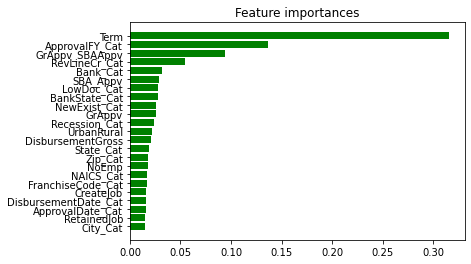

In [26]:
feature_import = list(zip(x_train.columns,model.feature_importances_))
df = pd.DataFrame(columns=['Feature', 'Importance'], data=feature_import)
df=df.sort_values(by=['Importance'])
plt.figure()
plt.title("Feature importances")
plt.barh(df['Feature'], df['Importance'],
       color="g", align="center", )
plt.savefig('xgboost.png', bbox_inches='tight')

### Train model with best params

In [ ]:
gsc = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'),
                   param_grid={'n_estimators': [i for i in range(150, 750, 10)],
                               'max_depth': [i for i in range(4, 34, 2)],
                               'learning_rate': [log(i) for i in np.arange(1.11, 1.27, 0.02)],
                               'gamma': [i for i in np.arange(0, 0.55, 0.05)],
                               'min_child_weight': [i for i in range(1, 11, 1)]
                              },
                   cv=10, scoring='accuracy', verbose=0)
best_model = gsc.fit(x_train, y_train)

In [104]:
def hyperopt_objective(params):
    model = xgb.XGBClassifier(n_estimators = params['n_estimators'],
#                               max_depth = int(params['max_depth']),
                              learning_rate = params['learning_rate'],
#                               gamma = params['gamma'],
#                               min_child_weight = params['min_child_weight'],
#                               subsample = params['subsample'],
#                               colsample_bytree = params['colsample_bytree']
                             )
    
    model.fit(x_train, y_train)

    accuracies = cross_val_score(estimator=model, X=x_train, y=y_train, cv=10)
    CrossValMean = accuracies.mean()

    return{'loss':1-CrossValMean, 'status': hyperopt.STATUS_OK }

In [ ]:
params_space = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
#     'max_depth' : hyperopt.hp.choice('max_depth', range(5, 30, 1)),
    'n_estimators' : hyperopt.hp.choice('n_estimators', range(20, 205, 5)),
#     'gamma' : hyperopt.hp.quniform('gamma', 0, 0.50, 0.01),
#     'min_child_weight' : hyperopt.hp.quniform('min_child_weight', 1, 10, 1),
#     'subsample' : hyperopt.hp.quniform('subsample', 0.1, 1, 0.01),
#     'colsample_bytree' : hyperopt.hp.quniform('colsample_bytree', 0.1, 1.0, 0.01)    
}

trials = hyperopt.Trials()

best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials
)

print(best)

### Predict

In [22]:
X_test = pd.read_csv('Xtest.csv')
X_testset = preprocessing.all_preprocess_with_label_encoding(X_test)

In [23]:
import pandas as pd
submisstion = pd.DataFrame()
submisstion['Id'] = X_test['Id']
submisstion['ChargeOff'] = model.predict(X_testset)

In [24]:
submisstion.to_csv('submission.csv', index=False)